In [2]:
import pandas as pd
import os

# Set your data directory
DATA_DIR = "data"

# Load both datasets
fake_df = pd.read_csv(os.path.join(DATA_DIR, "Fake.csv"))
real_df = pd.read_csv(os.path.join(DATA_DIR, "True.csv"))

# Inspect basic structure
print("Fake news shape:", fake_df.shape)
print("Real news shape:", real_df.shape)

# Standardize column names
fake_df.columns = [c.lower().strip() for c in fake_df.columns]
real_df.columns = [c.lower().strip() for c in real_df.columns]

# Some datasets use 'text', others 'content' or 'article'
text_col = "text" if "text" in fake_df.columns else "content"

# Add label column
fake_df["label"] = "FAKE"
real_df["label"] = "REAL"

# Combine and shuffle
df = pd.concat([fake_df[[text_col, "label"]], real_df[[text_col, "label"]]], axis=0).dropna().sample(frac=1, random_state=42)

print("Combined dataset:", df.shape)
df.head()


Fake news shape: (23481, 4)
Real news shape: (21417, 4)
Combined dataset: (44898, 2)


,text,label
22216,"21st Century Wire says Ben Stein, reputable pr...",FAKE
4436,WASHINGTON (Reuters) - U.S. President Donald T...,REAL
1526,(Reuters) - Puerto Rico Governor Ricardo Rosse...,REAL
1377,"On Monday, Donald Trump once again embarrassed...",FAKE
8995,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",REAL


In [3]:
os.makedirs("../../data", exist_ok=True)
df.to_csv(os.path.join(DATA_DIR, "fake_or_real_news.csv"), index=False)
print("Saved combined dataset as fake_or_real_news.csv")


Saved combined dataset as fake_or_real_news.csv


#IMPORT AND SETUP

In [4]:
import pandas as pd, numpy as np, re, os, joblib, json, nltk, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords; from nltk.stem import WordNetLemmatizer




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
DATA_PATH = "./data/fake_or_real_news.csv"
MODELS_DIR = "./models"
os.makedirs(MODELS_DIR, exist_ok=True)

#DATA CLEANING

In [6]:
def clean_text(t):
    t = re.sub(r"http\S+","",t)
    t = re.sub(r"[^a-zA-Z]"," ",t.lower())
    tokens = [lemmatizer.lemmatize(w) for w in t.split() if w not in stop_words and len(w)>1]
    return " ".join(tokens)

df = pd.read_csv(DATA_PATH).dropna(subset=["text","label"])
df["clean_text"] = df["text"].map(clean_text)
df["label_bin"] = df["label"].map(lambda x: 1 if x.lower().startswith("fake") else 0)
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label_bin"], test_size=0.2, stratify=df["label_bin"])
print(df["label"].value_counts())


label
FAKE    23481
REAL    21417
Name: count, dtype: int64


#Model 1 – TF-IDF + Logistic Regression

In [9]:
vec = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
X_train_vec, X_test_vec = vec.fit_transform(X_train), vec.transform(X_test)
logreg = LogisticRegression(max_iter=2000, class_weight="balanced")
logreg.fit(X_train_vec, y_train)
y_pred_lr = logreg.predict(X_test_vec)

acc_lr = accuracy_score(y_test, y_pred_lr)
p_lr, r_lr, f_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average="binary")
print(classification_report(y_test, y_pred_lr))

joblib.dump(logreg, f"{MODELS_DIR}/tfidf_logreg.pkl")
joblib.dump(vec, f"{MODELS_DIR}/tfidf_vectorizer.pkl")
metrics_lr = dict(accuracy=acc_lr, precision=p_lr, recall=r_lr, f1=f_lr)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



#Model 2 – BiLSTM (Keras)

In [10]:
tok = Tokenizer(num_words=20000, oov_token="<OOV>")
tok.fit_on_texts(X_train)
X_train_seq = pad_sequences(tok.texts_to_sequences(X_train), maxlen=300)
X_test_seq  = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=300)

model_lstm = Sequential([
    Embedding(20000,128,input_length=300),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64,activation="relu"),
    Dropout(0.2),
    Dense(1,activation="sigmoid")
])
model_lstm.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model_lstm.fit(X_train_seq,y_train,epochs=3,batch_size=64,validation_split=0.1,verbose=1)

pred_lstm = (model_lstm.predict(X_test_seq)>0.5).astype(int)
acc_lstm = accuracy_score(y_test,pred_lstm)
p_lstm,r_lstm,f_lstm,_ = precision_recall_fscore_support(y_test,pred_lstm,average="binary")
metrics_lstm = dict(accuracy=acc_lstm,precision=p_lstm,recall=r_lstm,f1=f_lstm)

model_lstm.save(f"{MODELS_DIR}/bilstm_model.h5")
joblib.dump(tok, f"{MODELS_DIR}/lstm_tokenizer.pkl")


d:\newsprep2\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
506/506 ━━━━━━━━━━━━━━━━━━━━ 306s 598ms/step - accuracy: 0.9588 - loss: 0.1118 - val_accuracy: 0.9833 - val_loss: 0.0586
Epoch 2/3
506/506 ━━━━━━━━━━━━━━━━━━━━ 294s 580ms/step - accuracy: 0.9882 - loss: 0.0388 - val_accuracy: 0.9897 - val_loss: 0.0351
Epoch 3/3
506/506 ━━━━━━━━━━━━━━━━━━━━ 332s 656ms/step - accuracy: 0.9803 - loss: 0.0551 - val_accuracy: 0.9841 - val_loss: 0.0539
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step


['./models/lstm_tokenizer.pkl']

#Model 3 – BERT (Transformers)

In [15]:
!pip install accelerate>=0.26.0

In [7]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_df = pd.DataFrame({"text":X_train, "labels":y_train})
test_df  = pd.DataFrame({"text":X_test,  "labels":y_test})
train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)
train_ds = train_ds.map(preprocess, batched=True)
test_ds  = test_ds.map(preprocess, batched=True)
train_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
test_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

from transformers import AutoModelForSequenceClassification
model_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir=f"{MODELS_DIR}/bert",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

def compute_metrics(eval_pred):
    import numpy as np
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds==labels).mean()
    p,r,f,_ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy":acc,"precision":p,"recall":r,"f1":f}

trainer = Trainer(model=model_bert,args=args,train_dataset=train_ds,eval_dataset=test_ds,compute_metrics=compute_metrics)
trainer.train()
res = trainer.evaluate()
metrics_bert = {k:float(v) for k,v in res.items() if "eval_" in k}
trainer.save_model(f"{MODELS_DIR}/bert")
tokenizer.save_pretrained(f"{MODELS_DIR}/bert")


Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\newsprep2\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.010900,0.006977,0.998775,0.998723,0.998935,0.998829


d:\newsprep2\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


('./models/bert\\tokenizer_config.json',
 './models/bert\\special_tokens_map.json',
 './models/bert\\vocab.txt',
 './models/bert\\added_tokens.json',
 './models/bert\\tokenizer.json')

#Comparison & Visualization

,Model,Accuracy,Precision,Recall,F1
0,TFIDF+LogReg,0.988864,0.991446,0.987223,0.989330
1,BiLSTM,0.978508,0.969160,0.990417,0.979674
2,BERT,0.998775,0.998723,0.998935,0.998829


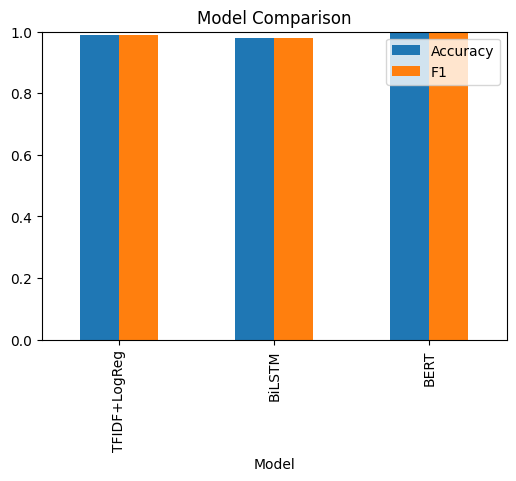

In [11]:
compare_df = pd.DataFrame([
    ["TFIDF+LogReg", metrics_lr["accuracy"], metrics_lr["precision"], metrics_lr["recall"], metrics_lr["f1"]],
    ["BiLSTM",       metrics_lstm["accuracy"], metrics_lstm["precision"], metrics_lstm["recall"], metrics_lstm["f1"]],
    ["BERT",         metrics_bert["eval_accuracy"], metrics_bert["eval_precision"], metrics_bert["eval_recall"], metrics_bert["eval_f1"]],
], columns=["Model","Accuracy","Precision","Recall","F1"])
display(compare_df)

compare_df.set_index("Model")[["Accuracy","F1"]].plot(kind="bar", figsize=(6,4), ylim=(0,1), title="Model Comparison")
plt.show()

# Save metrics
with open(f"{MODELS_DIR}/comparison_metrics.json","w") as f:
    json.dump(compare_df.set_index("Model").to_dict(orient="index"),f,indent=2)


#Quick Prediction Function

In [12]:
from transformers import pipeline
bert_pipe = pipeline("text-classification", model=f"{MODELS_DIR}/bert", tokenizer=f"{MODELS_DIR}/bert")
def predict_all(text):
    clean = clean_text(text)
    # TF-IDF
    x = vec.transform([clean])
    pred_lr = int(logreg.predict(x)[0])
    prob_lr = float(logreg.predict_proba(x)[0][1])
    # LSTM
    seq = pad_sequences(tok.texts_to_sequences([clean]), maxlen=300)
    prob_lstm = float(model_lstm.predict(seq)[0][0])
    pred_lstm = int(prob_lstm>0.5)
    # BERT
    out = bert_pipe(text[:10000])[0]
    prob_bert = out["score"]; pred_bert = 1 if "1" in out["label"] else 0
    return {"tfidf":(pred_lr,prob_lr),"lstm":(pred_lstm,prob_lstm),"bert":(pred_bert,prob_bert)}

predict_all("Aliens invade earth, government confirms landing.")


Device set to use cpu


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


{'tfidf': (1, 0.9107369515385062),
 'lstm': (1, 0.9933327436447144),
 'bert': (1, 0.999695897102356)}

In [13]:
!pip install gensim pyldavis bertopic[all] sentence-transformers chromadb faiss-cpu


     ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
     - -------------------------------------- 0.3/6.9 MB ? eta -:--:--
     ---- ----------------------------------- 0.8/6.9 MB 7.8 MB/s eta 0:00:01
     ---------- ----------------------------- 1.8/6.9 MB 3.6 MB/s eta 0:00:02
     --------------- ------------------------ 2.6/6.9 MB 3.6 MB/s eta 0:00:02
     ------------------ --------------------- 3.1/6.9 MB 3.4 MB/s eta 0:00:02
     ---------------------- ----------------- 3.9/6.9 MB 3.4 MB/s eta 0:00:01
     ------------------------- -------------- 4.5/6.9 MB 3.3 MB/s eta 0:00:01
     ------------------------------ --------- 5.2/6.9 MB 3.4 MB/s eta 0:00:01
     ---------------------------------- ----- 6.0/6.9 MB 3.4 MB/s eta 0:00:01
     ---------------------------------------- 6.9/6.9 MB 3.4 MB/s  0:00:02
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting 

In [14]:
# assumes df and clean_text exist from earlier cells
docs = df["text"].tolist()             # original texts (for BERTopic & recommender)
clean_docs = df["clean_text"].tolist() # tokenized/cleaned texts for LDA
texts = [t.split() for t in clean_docs]

print("Docs:", len(docs))


Docs: 44898


In [15]:
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
import json, os

LDA_OUT = f"{MODELS_DIR}/lda"
os.makedirs(LDA_OUT, exist_ok=True)

# Create dictionary and corpus
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=50000)
corpus = [id2word.doc2bow(text) for text in texts]

# Train LDA
NUM_TOPICS = 10
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=NUM_TOPICS, random_state=42, passes=10, chunksize=2000)

# Save
lda_model.save(os.path.join(LDA_OUT, "lda.model"))
id2word.save(os.path.join(LDA_OUT, "id2word.dict"))

# Extract topic keywords
lda_topics = {i: [word for word, _ in lda_model.show_topic(i, topn=8)] for i in range(NUM_TOPICS)}
with open(os.path.join(LDA_OUT, "lda_topics.json"), "w") as f:
    json.dump(lda_topics, f, indent=2)

print("Saved LDA model and topics. Example topics:")
for k,v in lda_topics.items():
    print(f"Topic {k}:", v)


Saved LDA model and topics. Example topics:
Topic 0: ['trump', 'donald', 'image', 'twitter', 'like', 'people', 'one', 'news']
Topic 1: ['woman', 'people', 'black', 'one', 'like', 'white', 'american', 'right']
Topic 2: ['republican', 'trump', 'election', 'clinton', 'party', 'campaign', 'vote', 'candidate']
Topic 3: ['republican', 'tax', 'house', 'bill', 'senate', 'trump', 'year', 'congress']
Topic 4: ['court', 'state', 'law', 'muslim', 'right', 'refugee', 'order', 'country']
Topic 5: ['trump', 'clinton', 'russian', 'russia', 'former', 'investigation', 'house', 'email']
Topic 6: ['company', 'million', 'year', 'new', 'government', 'state', 'wire', 'u']
Topic 7: ['police', 'year', 'people', 'gun', 'city', 'officer', 'two', 'one']
Topic 8: ['state', 'trump', 'united', 'north', 'china', 'korea', 'nuclear', 'reuters']
Topic 9: ['government', 'reuters', 'minister', 'state', 'eu', 'syria', 'year', 'country']


In [17]:
df.head()

,text,label,clean_text,label_bin,lda_topic
0,"21st Century Wire says Ben Stein, reputable pr...",FAKE,st century wire say ben stein reputable profes...,1,4
1,WASHINGTON (Reuters) - U.S. President Donald T...,REAL,washington reuters president donald trump remo...,0,5
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,REAL,reuters puerto rico governor ricardo rossello ...,0,3
3,"On Monday, Donald Trump once again embarrassed...",FAKE,monday donald trump embarrassed country accide...,1,0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",REAL,glasgow scotland reuters presidential candidat...,0,2


In [18]:
# returns dominant topic id for each doc
def lda_get_topic_for_doc(doc_text):
    bow = id2word.doc2bow(clean_text(doc_text).split())
    topic_probs = lda_model.get_document_topics(bow)
    if not topic_probs:
        return None
    topic_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    return topic_probs[0][0]

# Example
df["title"] = df["text"].apply(lambda t: t[:50] + "...")
df["lda_topic"] = df["text"].apply(lambda t: lda_get_topic_for_doc(t))
df[["title","lda_topic"]].head()


,title,lda_topic
0,"21st Century Wire says Ben Stein, reputable pr...",4
1,WASHINGTON (Reuters) - U.S. President Donald T...,5
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,3
3,"On Monday, Donald Trump once again embarrassed...",0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",2


In [21]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import os
import json

# Paths
BER_OUT_FILE = os.path.join(MODELS_DIR, "bertopic.pkl")
BER_INFO_FILE = os.path.join(MODELS_DIR, "bertopic_info.json")

# Load embedding model (CPU by default)
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# Fit BERTopic
print("Training BERTopic...")
topic_model = BERTopic(
    embedding_model=sbert,
    nr_topics="auto"
)

topics, probs = topic_model.fit_transform(docs)

# Save BERTopic as single .pkl file
topic_model.save(BER_OUT_FILE)
print(f"Saved BERTopic to {BER_OUT_FILE}")

# Save topic info
topic_info = topic_model.get_topic_info()
topic_info.to_json(BER_INFO_FILE, orient="records")
print(f"Saved BERTopic topic info to {BER_INFO_FILE}")

topic_info.head()


Training BERTopic...


2025-11-21 09:32:32,645 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved BERTopic to ./models\bertopic.pkl
Saved BERTopic topic info to ./models\bertopic_info.json


,Topic,Count,Name,Representation,Representative_Docs
0,-1,13600,-1_trump_is_that_and,"[trump, is, that, and, to, he, the, of, you, his]","[The GOP doesn t know it yet, but they need Tr..."
1,0,1523,0_flynn_russia_russian_comey,"[flynn, russia, russian, comey, intelligence, ...",[WASHINGTON (Reuters) - Former FBI Director Ja...
2,1,1340,1_kurdish_syria_iraqi_iraq,"[kurdish, syria, iraqi, iraq, turkey, syrian, ...","[ERBIL/SULAIMANIYA, Iraq (Reuters) - Kurds vot..."
3,2,1021,2_tax_obamacare_insurance_healthcare,"[tax, obamacare, insurance, healthcare, bill, ...",[WASHINGTON (Reuters) - President Donald Trump...
4,3,825,3_gun_police_guns_nra,"[gun, police, guns, nra, protesters, officers,...",[WASHINGTON (Reuters) - A long-running battle ...


In [22]:
def bertopic_get_topics_for_text(text, top_n=3):
    t, p = topic_model.transform([text])
    return t[0]  # main topic id (or return (t,p) for probabilities)

# Example
sample = docs[0]
print("Main BERTopic for sample:", bertopic_get_topics_for_text(sample))


Main BERTopic for sample: -1


In [23]:
# 1) Inspect the sample length and content
sample = docs[0]
print("len chars:", len(sample))
print("len words:", len(sample.split()))
print(sample[:1000])  # first 1000 chars to inspect content

# 2) What does BERTopic return with probabilities?
topic_ids, probs = topic_model.transform([sample])
print("topic_ids:", topic_ids)
print("probs:", probs)   # array of probabilities (may be [None] if -1)


len chars: 1028
len words: 171
21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein went on to call the Judges in Seattle  political puppets  and the judiciary  political pawns. Watch the interview below for the complete statements and note the stark contrast to the rhetoric of the leftist media and pundits who neglect to note that no court has ever blocked any Presidential orders in immigration in the past or discuss the legal efficacy of the halt or the actual text of the Executive Order.READ MORE TRUMP NEWS AT: 21st Century Wire Trump FilesSUP

In [24]:
topic_model.get_topic(1)


[('kurdish', np.float64(0.008593305923729545)),
 ('syria', np.float64(0.007721509848402785)),
 ('iraqi', np.float64(0.006996847527305464)),
 ('iraq', np.float64(0.006951036752007013)),
 ('turkey', np.float64(0.00645211579029993)),
 ('syrian', np.float64(0.0063462575664740475)),
 ('islamic', np.float64(0.005993742958483475)),
 ('ban', np.float64(0.004897971830057602)),
 ('al', np.float64(0.004619179786299903)),
 ('baghdad', np.float64(0.0045896983166021175))]

In [25]:
topic_model.get_topic(1)
topic_model.get_topic_info().head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,13600,-1_trump_is_that_and,"[trump, is, that, and, to, he, the, of, you, his]","[The GOP doesn t know it yet, but they need Tr..."
1,0,1523,0_flynn_russia_russian_comey,"[flynn, russia, russian, comey, intelligence, ...",[WASHINGTON (Reuters) - Former FBI Director Ja...
2,1,1340,1_kurdish_syria_iraqi_iraq,"[kurdish, syria, iraqi, iraq, turkey, syrian, ...","[ERBIL/SULAIMANIYA, Iraq (Reuters) - Kurds vot..."
3,2,1021,2_tax_obamacare_insurance_healthcare,"[tax, obamacare, insurance, healthcare, bill, ...",[WASHINGTON (Reuters) - President Donald Trump...
4,3,825,3_gun_police_guns_nra,"[gun, police, guns, nra, protesters, officers,...",[WASHINGTON (Reuters) - A long-running battle ...


In [ ]:
topic_model = BERTopic(embedding_model=sbert, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

topic_model.generate_topic_labels(nr_words=5, topic_prefix=False)


2025-11-21 09:48:28,440 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1404 [00:00<?, ?it/s]

2025-11-21 10:12:46,244 - BERTopic - Embedding - Completed ✓
2025-11-21 10:12:46,295 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-21 10:13:09,989 - BERTopic - Dimensionality - Completed ✓
2025-11-21 10:13:10,009 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-21 10:36:26,532 - BERTopic - Cluster - Completed ✓
2025-11-21 10:36:26,991 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-21 10:36:54,489 - BERTopic - Representation - Completed ✓


In [ ]:
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
import os, json

# initialize
CHROMA_DIR = f"{MODELS_DIR}/chroma_db"
os.makedirs(CHROMA_DIR, exist_ok=True)

# If running locally, point Chroma to persisted directory
client = chromadb.Client(Settings(chroma_db_impl="duckdb+parquet", persist_directory=CHROMA_DIR))
collection_name = "articles"
try:
    collection = client.get_collection(collection_name)
except Exception:
    collection = client.create_collection(collection_name)

sbert = SentenceTransformer("all-MiniLM-L6-v2")  # already loaded above, but reassign safe
# create embeddings in batches for memory safety
BATCH = 256
ids = []
metadatas = []
docs_to_index = []
embeddings = []

for i in range(0, len(docs), BATCH):
    batch_docs = docs[i:i+BATCH]
    embs = sbert.encode(batch_docs, show_progress_bar=True, convert_to_numpy=True)
    ids_batch = [f"doc_{i+j}" for j in range(len(batch_docs))]
    metas_batch = [{"title": df.iloc[i+j].get("title",""), "index": int(i+j)} for j in range(len(batch_docs))]
    collection.add(ids=ids_batch, embeddings=embs.tolist(), documents=batch_docs, metadatas=metas_batch)

# persist
client.persist()
print("Indexed documents into Chroma. Total items:", len(collection.get()))


In [ ]:
def get_similar_articles(text, k=5):
    q_emb = sbert.encode([text], convert_to_numpy=True)
    res = collection.query(query_embeddings=q_emb.tolist(), n_results=k, include=["metadatas","documents","distances"])
    # format results
    if res and len(res["ids"])>0:
        hits = []
        for i in range(len(res["ids"][0])):
            hits.append({
                "id": res["ids"][0][i],
                "title": res["metadatas"][0][i].get("title",""),
                "index": res["metadatas"][0][i].get("index"),
                "score": res["distances"][0][i],
                "text_snippet": res["documents"][0][i][:300]
            })
        return hits
    return []

# Example
sim = get_similar_articles("The government announced a new economic stimulus package.", k=3)
sim


In [ ]:
# assumes tfidf/logreg, vec, model_lstm, tok, model_bert, bert_pipe already available from previous notebook cells
def predict_all_enhanced(text, k_similar=5):
    cleaned = clean_text(text)
    # TF-IDF
    x_tfidf = vec.transform([cleaned])
    tf_pred = int(logreg.predict(x_tfidf)[0])
    tf_prob = float(logreg.predict_proba(x_tfidf)[0][1])
    # LSTM
    seq = pad_sequences(tok.texts_to_sequences([cleaned]), maxlen=300)
    lstm_prob = float(model_lstm.predict(seq)[0][0])
    lstm_pred = int(lstm_prob > 0.5)
    # BERT
    bert_out = bert_pipe(text[:10000])[0]  # careful with long text
    bert_score = bert_out["score"]
    bert_label = bert_out["label"]
    bert_pred = 1 if "1" in str(bert_label) else 0

    # Topics
    lda_t = None
    try:
        lda_t = lda_get_topic_for_doc(text)
    except Exception:
        lda_t = None
    bertopic_t = None
    try:
        bertopic_t = topic_model.transform([text])[0]
    except Exception:
        bertopic_t = None

    # Similar items
    similar = get_similar_articles(text, k=k_similar)

    return {
        "tfidf": {"pred": tf_pred, "prob": tf_prob},
        "lstm": {"pred": lstm_pred, "prob": lstm_prob},
        "bert": {"pred": bert_pred, "prob": bert_score},
        "lda_topic": int(lda_t) if lda_t is not None else None,
        "bertopic_topic": int(bertopic_t) if bertopic_t is not None else None,
        "similar": similar
    }

# Quick test
res = predict_all_enhanced("The central bank raised interest rates to tackle inflation.")
res


In [ ]:
topic_model.visualize_topics()  # opens interactive plot in notebook


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)
